<a href="https://colab.research.google.com/github/giovanni-agra/PostPartum-Analysis-Thailand/blob/main/Data_Analysis_Aj_Sasilak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df = pd.read_csv('/content/drive/MyDrive/Dataset_Sasilak_2025.csv')

In [11]:
# Checking dimensions (rows, columns)
print(f"Dataset dimensions: {df.shape}")

# Examine variable names and data types
print("\nColumn names and data types:")
print(df.dtypes)

# View sample rows to understand context
print("\nSample rows:")
print(df.head())

# Basic summary statistics
print("\nSummary statistics:")
print(df.describe())

Dataset dimensions: (252, 165)

Column names and data types:
No                                                                                                                   object
Schoolcode                                                                                                          float64
Number                                                                                                              float64
Age                                                                                                                 float64
What kind of area do you live in? (Please choose one).                                                               object
                                                                                                                     ...   
27 Education background of your partner                                                                             float64
28.1 Have you recently visited a hospital for any physical illness?    

# Data Quality Assessment for Ajarn Sasilak's Dataset

In this notebook, we'll perform a thorough quality assessment of the postpartum support dataset. Based on our initial exploration, we know we're working with 252 rows and 165 columns, with the first row containing metadata rather than actual data.

In [12]:
# Make sure we're using the cleaned dataframe (excluding the metadata row)
df_clean = df.iloc[1:].reset_index(drop=True)
print(f"Cleaned dataset dimensions: {df_clean.shape}")

Cleaned dataset dimensions: (251, 165)


## 1. Missing Values Analysis

Let's examine the extent of missing data in our dataset. We'll identify columns with the highest percentages of missing values.

Columns with missing values:
                                                    Missing Values  Percentage
Unnamed: 21                                                    238   94.820717
Unnamed: 37                                                    236   94.023904
10 This question is for those who have already ...               2    0.796813
12 Husband's (partner's) work hours : Working h...               1    0.398406


<ipython-input-13-a49f81dd4efc>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


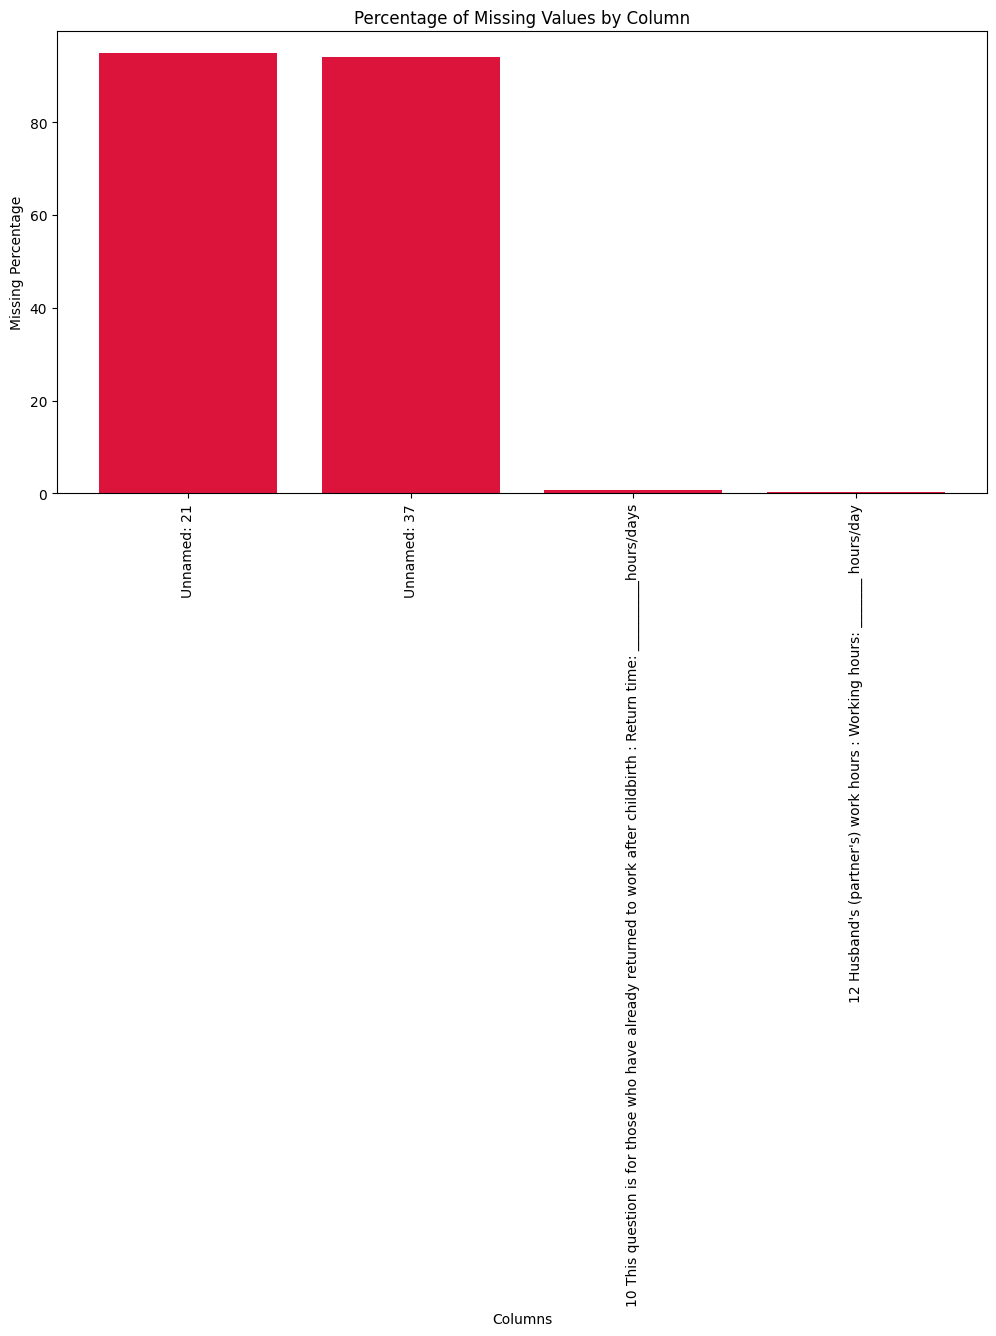

In [13]:
# Check for missing values with more detail
missing_values = df_clean.isnull().sum()
missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100
missing_data = pd.concat([missing_values, missing_percent], axis=1)
missing_data.columns = ['Missing Values', 'Percentage']

# Display columns with missing values, sorted by percentage
print("Columns with missing values:")
missing_results = missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print(missing_results.head(20))

# Visualize missing data for columns with highest missing percentages
plt.figure(figsize=(12, 6))
plt.bar(missing_results.index[:15], missing_results['Percentage'][:15], color='crimson')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Missing Percentage')
plt.title('Percentage of Missing Values by Column')
plt.tight_layout()
plt.show()

## 2. Check for Duplicates

Let's identify any duplicate rows in the dataset.

In [14]:
# Check for exact duplicates
duplicates = df_clean.duplicated().sum()
print(f"Number of exact duplicates: {duplicates}")

# Check for potential near-duplicates based on key identifying columns
# Assuming 'No' or a combination of demographic columns might identify unique respondents
if 'No' in df_clean.columns:
    dup_counts = df_clean['No'].value_counts()
    print("\nPotential duplicate IDs:")
    print(dup_counts[dup_counts > 1])

Number of exact duplicates: 0

Potential duplicate IDs:
Series([], Name: count, dtype: int64)


## 3. Data Type Consistency

Many columns may have improper data types due to the metadata row. Let's identify columns that should be numeric and check their current types.

In [15]:
# Attempt to convert columns to proper types
numeric_cols = []
conversion_issues = []

for col in df_clean.columns:
    try:
        # Try converting to numeric and check if any values were actually converted
        converted = pd.to_numeric(df_clean[col], errors='coerce')
        # If most values are not NaN after conversion, it's likely a numeric column
        if converted.notna().sum() > 0.5 * len(df_clean):
            numeric_cols.append(col)
            # Apply the conversion
            df_clean[col] = converted
    except:
        conversion_issues.append(col)

print(f"Successfully identified {len(numeric_cols)} numeric columns")
print(f"First 10 numeric columns: {numeric_cols[:10]}")

Successfully identified 149 numeric columns
First 10 numeric columns: ['No', 'Schoolcode', 'Number', 'Age', 'What is your current marital status?', 'Partner age', 'number of children', 'familymember', '6-1 How far aparts do your child(ren) and Maternal grandfather live from each other?', '6-2 How far aparts do your child(ren) and Maternal grandmother live from each other?']


## 4. Examining Ranges and Outliers

Let's analyze the range of values in numeric columns and identify potential outliers.


Statistical summary for demographic variables:
              Age  Partner age  number of children
count  251.000000   251.000000          251.000000
mean    34.350598    32.705179            1.501992
std      5.703033    13.117650            0.634820
min     17.000000     0.000000            1.000000
25%     30.500000    31.000000            1.000000
50%     34.000000    36.000000            1.000000
75%     39.000000    40.000000            2.000000
max     52.000000    55.000000            4.000000

Columns with potential outliers (|z-score| > 3):
                                               Column  Outlier Count  \
4   9 This question is for those who have not yet ...             16   
13  14.14 One or both of you say cruel or hurtful ...             13   
1                What is your current marital status?             10   
7   14.2 My relationship with mypartner is stronge...              8   
15            15.2 Cleaning up after meals : Yourself              8   
25  16.6 Ta

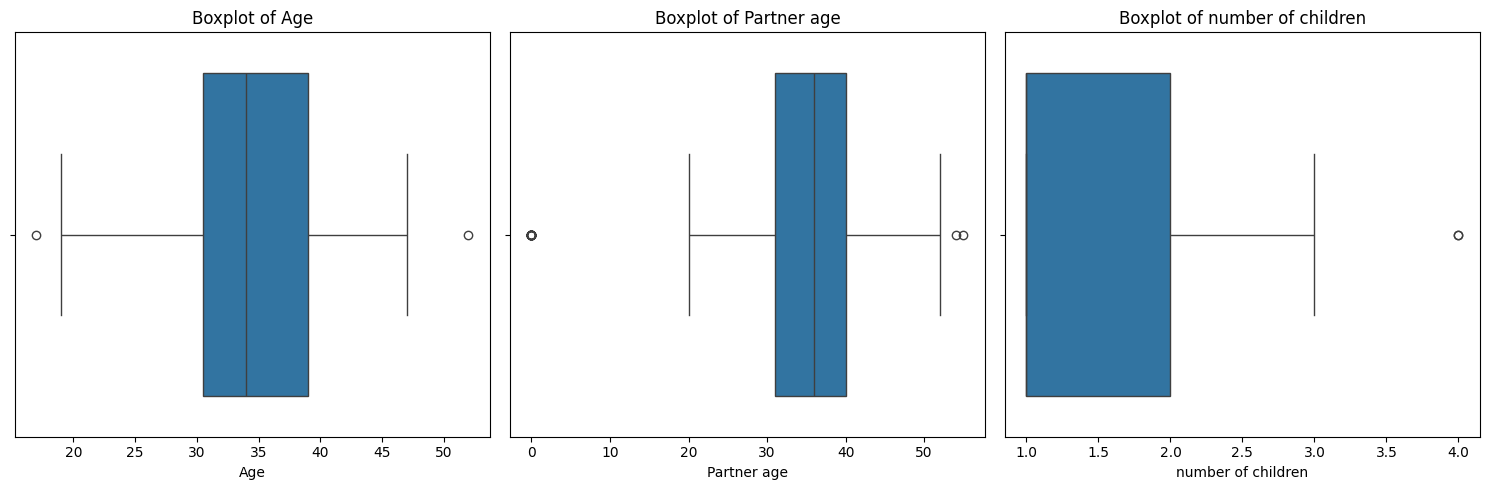

In [16]:
# Display summary statistics for key numeric variables
print("\nStatistical summary for demographic variables:")
demographic_cols = [col for col in numeric_cols if col in ['Age', 'Partner age', 'number of children']]
if demographic_cols:
    print(df_clean[demographic_cols].describe())

# Function to detect outliers using z-score method
def detect_outliers(df, column):
    values = pd.to_numeric(df[column], errors='coerce')
    if values.count() > 10:  # Only analyze if we have enough non-null values
        z_scores = stats.zscore(values.dropna())
        outliers = (abs(z_scores) > 3).sum()
        outlier_percent = (outliers / values.count()) * 100
        return outliers, outlier_percent
    return 0, 0

# Check for outliers in numeric columns
outlier_results = []
for col in numeric_cols:
    outliers, outlier_percent = detect_outliers(df_clean, col)
    if outliers > 0:
        outlier_results.append([col, outliers, outlier_percent])

# Display columns with outliers
if outlier_results:
    outlier_df = pd.DataFrame(outlier_results, columns=['Column', 'Outlier Count', 'Outlier Percentage'])
    print("\nColumns with potential outliers (|z-score| > 3):")
    print(outlier_df.sort_values('Outlier Count', ascending=False).head(10))

    # Visualize outliers for a few key variables
    if demographic_cols:
        plt.figure(figsize=(15, 5))
        for i, col in enumerate(demographic_cols[:3]):
            plt.subplot(1, 3, i+1)
            sns.boxplot(x=df_clean[col])
            plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

## 5. Categorical Variable Analysis

Now let's examine the distribution of categorical variables to identify any imbalance.


Detected 16 categorical columns

Value distribution for What kind of area do you live in? (Please choose one).:
                                                    Count  Percentage
What kind of area do you live in? (Please choos...                   
home                                                  175   69.721116
condo                                                  29   11.553785
Townhouse                                              19    7.569721
rent room                                               7    2.788845
apartment                                               7    2.788845
shop house                                              5    1.992032
home renting                                            5    1.992032
government home                                         3    1.195219
house in factory                                        1    0.398406


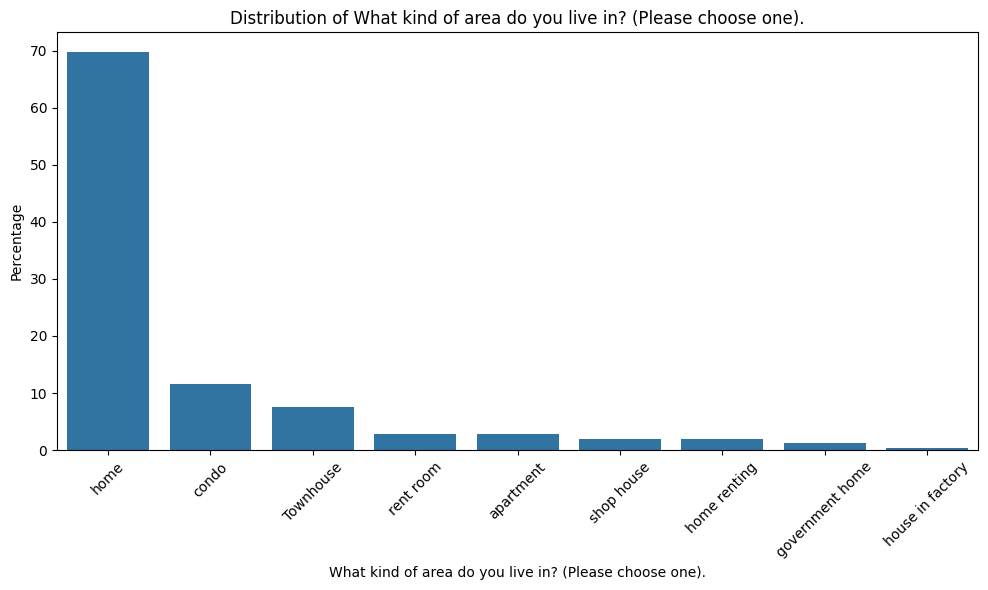


Value distribution for What is your current marital status?:
                                      Count  Percentage
What is your current marital status?                   
1                                       232   92.430279
3                                        10    3.984064
2                                         5    1.992032
0                                         4    1.593625


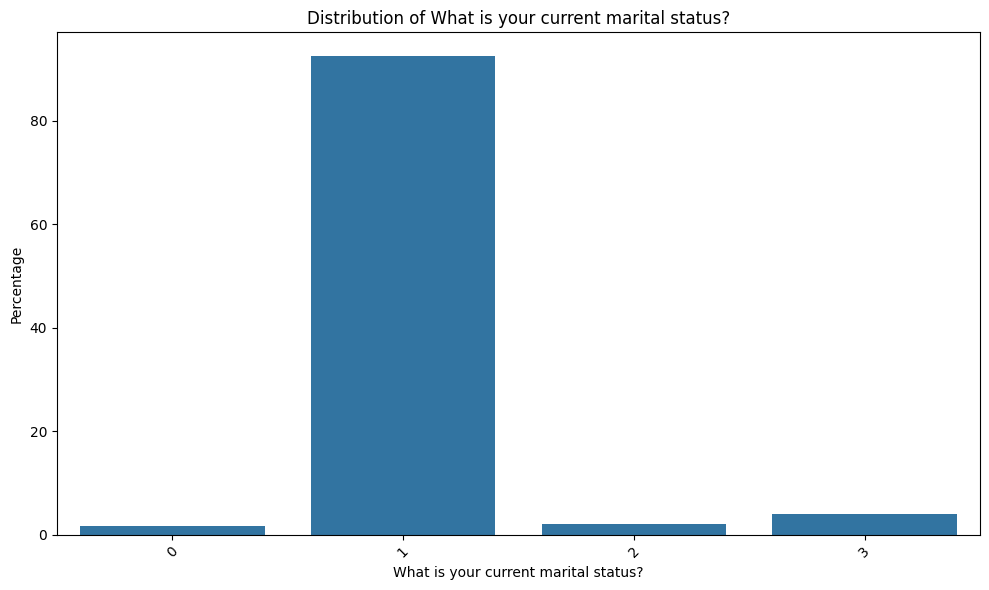


Value distribution for Child gender:
              Count  Percentage
Child gender                   
F                93   37.051793
M                86   34.262948
none             72   28.685259


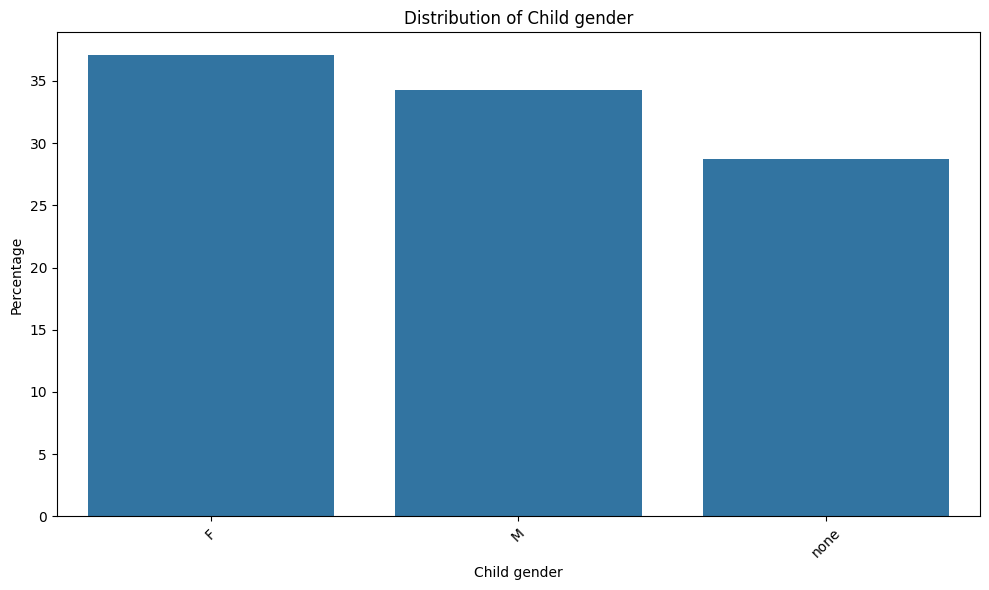

In [17]:
# Identify categorical columns (non-numeric)
categorical_cols = [col for col in df_clean.columns if col not in numeric_cols]
print(f"\nDetected {len(categorical_cols)} categorical columns")

# Analyze a few important categorical variables
key_categorical = [
    'What kind of area do you live in? (Please choose one).',
    'What is your current marital status?',
    'Child gender'
]

for col in key_categorical:
    if col in df_clean.columns:
        print(f"\nValue distribution for {col}:")
        value_counts = df_clean[col].value_counts()
        value_percent = (df_clean[col].value_counts() / len(df_clean)) * 100
        distribution = pd.concat([value_counts, value_percent], axis=1)
        distribution.columns = ['Count', 'Percentage']
        print(distribution)

        # Visualize the distribution
        plt.figure(figsize=(10, 6))
        sns.barplot(x=distribution.index, y='Percentage', data=distribution)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 6. Inconsistent Formatting Check

Let's check for inconsistent formatting in key text variables.

In [18]:
# Examine format consistency in text columns
print("\nChecking for inconsistent formatting in key text variables...")
for col in categorical_cols[:5]:  # First 5 categorical columns
    unique_values = df_clean[col].dropna().unique()
    print(f"\nSample of unique values in {col} ({len(unique_values)} total):")
    # Show a sample of unique values (up to 10)
    sample_size = min(10, len(unique_values))
    print(unique_values[:sample_size])

    # Check for potential issues like leading/trailing spaces
    space_issues = sum(df_clean[col].astype(str).str.startswith(' ') |
                     df_clean[col].astype(str).str.endswith(' '))
    if space_issues > 0:
        print(f"Warning: {space_issues} values have leading or trailing spaces")


Checking for inconsistent formatting in key text variables...

Sample of unique values in What kind of area do you live in? (Please choose one). (9 total):
['home' 'condo' 'Townhouse' 'rent room' 'shop house' 'home renting'
 'apartment' 'government home' 'house in factory']

Sample of unique values in Child gender (3 total):
['M' 'F' 'none']

Sample of unique values in Please indicate your child's gender, age, and enrollment status. ______ (176 total):
['1-2y-M-Nur' '1-2.7y-F-Nur' '1-11y-F-Pri, 2-1.8y-M-Nur'
 '1-2.4y-M-Nur, 2-7m15d-F-Grandma' '1-6.6y-F-K3, 2-1.8y-F-Nur'
 '1-1.4y-M-Nur' '1-2.5y-F-Nur' '1-11m-F-Nur' '1-3y-M-Kin, 2-9m-F-Nur'
 '1-18y-Uni, 2-5m-F-Nur']

Sample of unique values in How many family members currently live with you? _____ people (98 total):
['3-1,2(1)' '4-1,2(1),6' '4-1,2(2)' '2-2(1)' '5-1,2(2),6' '5-1,2(3)'
 '6-1,2(1),4,9(ยาย หลาน น้า)' '7-1,2(2),3,4,9(พี่สาว)'
 '5-1,2(1),4,9(น้องชาย)' '5-1,2(1),4,9(น้องสาว หลานสาว)']

Sample of unique values in Unnamed: 21 (7

## 7. Data Quality Summary

Based on our analysis, here's a summary of the data quality issues found and recommendations for data cleaning.

In [19]:
# Create a summary of data quality issues found
print("DATA QUALITY ASSESSMENT SUMMARY")
print("===============================")
print(f"1. Dataset dimensions after removing metadata row: {df_clean.shape}")
print(f"2. Missing values: {missing_values.sum()} total across {len(missing_results)} columns")
print(f"3. Duplicate rows: {duplicates}")
print(f"4. Columns with outliers: {len(outlier_results) if 'outlier_results' in locals() else 'Not calculated'}")
print(f"5. Numeric columns identified: {len(numeric_cols)}")
print(f"6. Categorical columns identified: {len(categorical_cols)}")
print("\nRecommended next steps for data cleaning:")
print("- Handle missing values (imputation or removal)")
print("- Address identified outliers")
print("- Standardize inconsistent formatting")
print("- Convert columns to appropriate data types")

DATA QUALITY ASSESSMENT SUMMARY
1. Dataset dimensions after removing metadata row: (251, 165)
2. Missing values: 477 total across 4 columns
3. Duplicate rows: 0
4. Columns with outliers: 58
5. Numeric columns identified: 149
6. Categorical columns identified: 16

Recommended next steps for data cleaning:
- Handle missing values (imputation or removal)
- Address identified outliers
- Standardize inconsistent formatting
- Convert columns to appropriate data types


### Removing Unnecessary Columns and Metadata Row

### Remove Unnecessary Columns and Metadata Row

In [20]:
# Create a clean dataframe without the metadata row
df_clean = df.iloc[1:].reset_index(drop=True)

# Identify columns with high missing value percentages (>90%)
missing_percent = df_clean.isnull().mean() * 100
high_missing_cols = missing_percent[missing_percent > 90].index.tolist()

# Display columns that will be removed
print(f"Columns to be removed due to >90% missing values:")
for col in high_missing_cols:
    print(f"- {col}: {missing_percent[col]:.2f}% missing")

# Drop columns with excessive missing values
df_clean = df_clean.drop(columns=high_missing_cols)
print(f"\nRemoved {len(high_missing_cols)} columns with >90% missing values")
print(f"Dataset dimensions after removing high-missing columns: {df_clean.shape}")

Columns to be removed due to >90% missing values:
- Unnamed: 21: 94.82% missing
- Unnamed: 37: 94.02% missing

Removed 2 columns with >90% missing values
Dataset dimensions after removing high-missing columns: (251, 163)


### Convert to Appropriate Data Types

In [21]:
# Convert obvious numeric columns
numeric_cols = ['Age', 'Partner age', 'number of children', 'Schoolcode', 'Number']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Display dtypes after conversion
print("Data types after conversion:")
print(df_clean[numeric_cols].dtypes)

Data types after conversion:
Age                   float64
Partner age           float64
number of children    float64
Schoolcode            float64
Number                float64
dtype: object


### Decode Child Information

In [23]:
# Parse child information (1-2y-M-Nur format)
# This decodes: number of child - age - gender - enrollment status
def parse_child_info(info_string):
    if pd.isna(info_string):
        return pd.NA, pd.NA, pd.NA, pd.NA

    # Handle multiple children
    children = []
    for child in str(info_string).split(', '):
        parts = child.split('-')
        if len(parts) >= 4:
            child_num = parts[0]
            age = parts[1]
            gender = parts[2]
            enrollment = parts[3]
            children.append({'child_num': child_num, 'age': age, 'gender': gender, 'enrollment': enrollment})
        elif len(parts) == 3:  # If missing one part
            child_num = parts[0]
            age = parts[1]
            gender = parts[2]
            enrollment = "Unknown"
            children.append({'child_num': child_num, 'age': age, 'gender': gender, 'enrollment': enrollment})

    # Return info for first child if available
    if children:
        return (children[0]['child_num'], children[0]['age'],
                children[0]['gender'], children[0]['enrollment'])
    return pd.NA, pd.NA, pd.NA, pd.NA

# Apply the parsing function
# Fix: Use double quotes for the column name with an apostrophe
child_info_col = "Please indicate your child's gender, age, and enrollment status. ______"
if child_info_col in df_clean.columns:
    parsed_info = df_clean[child_info_col].apply(parse_child_info)

    # Create new columns with the parsed information
    df_clean['first_child_num'] = [x[0] for x in parsed_info]
    df_clean['first_child_age'] = [x[1] for x in parsed_info]
    df_clean['first_child_gender'] = [x[2] for x in parsed_info]
    df_clean['first_child_enrollment'] = [x[3] for x in parsed_info]

    # Display sample of parsed child information
    print("Sample of parsed child information:")
    sample_cols = ['first_child_num', 'first_child_age', 'first_child_gender', 'first_child_enrollment']
    print(df_clean[sample_cols].head(10))

Sample of parsed child information:
  first_child_num first_child_age first_child_gender first_child_enrollment
0               1              2y                  M                    Nur
1               1            2.7y                  F                    Nur
2               1              2y                  M                    Nur
3               1             11y                  F                    Pri
4               1            2.4y                  M                    Nur
5               1            6.6y                  F                     K3
6               1            1.4y                  M                    Nur
7               1            2.7y                  F                    Nur
8               1            2.5y                  F                    Nur
9               1              2y                  M                    Nur


### Decode Family Member Information

In [24]:
# Parse family member information (total of family member-code,code(number),code)
def parse_family_members(info_string):
    if pd.isna(info_string):
        return pd.NA, []

    # Extract total family members
    parts = str(info_string).split('-')
    total_members = parts[0] if len(parts) > 0 else pd.NA

    # Extract codes
    codes = []
    if len(parts) > 1 and len(parts[1]) > 0:
        # Extract codes and numbers in parentheses
        code_part = parts[1]
        # Find all patterns like "1,2(1)" or "3,4,9(ยาย หลาน น้า)"
        code_matches = re.findall(r'(\d+(?:,\d+)*)\(([^)]+)\)', code_part)

        for match in code_matches:
            code_nums = match[0].split(',')
            code_desc = match[1]
            for num in code_nums:
                codes.append({'code': num, 'description': code_desc})

    return total_members, codes

# Apply the parsing function
family_col = 'How many family members currently live with you? _____ people'
if family_col in df_clean.columns:
    parsed_family = df_clean[family_col].apply(parse_family_members)

    # Create new columns with the parsed information
    df_clean['total_family_members'] = [x[0] for x in parsed_family]

    # Create indicator columns for common family members
    member_codes = {
        '1': 'has_husband',
        '2': 'has_children',
        '3': 'has_father',
        '4': 'has_mother',
        '5': 'has_father_in_law',
        '6': 'has_mother_in_law',
        '7': 'has_housekeeper',
        '8': 'has_caretaker',
        '9': 'has_other_relatives'
    }

    for code, col_name in member_codes.items():
        df_clean[col_name] = parsed_family.apply(
            lambda x: any(c['code'] == code for c in x[1]) if isinstance(x[1], list) else False
        )

    # Display sample of parsed family information
    print("\nSample of parsed family member information:")
    family_cols = ['total_family_members'] + list(member_codes.values())
    print(df_clean[family_cols].head(10))


Sample of parsed family member information:
  total_family_members  has_husband  has_children  has_father  has_mother  \
0                    3         True          True       False       False   
1                    3         True          True       False       False   
2                    4         True          True       False       False   
3                    4         True          True       False       False   
4                    2        False          True       False       False   
5                    4         True          True       False       False   
6                    3         True          True       False       False   
7                    3         True          True       False       False   
8                    3         True          True       False       False   
9                    3         True          True       False       False   

   has_father_in_law  has_mother_in_law  has_housekeeper  has_caretaker  \
0              False            

### Flag Outliers for Analysis

In [25]:
# Identify outliers in key numeric variables
outlier_cols = ['Age', 'Partner age', 'number of children']

for col in outlier_cols:
    if col in df_clean.columns:
        # Calculate z-scores
        z_scores = stats.zscore(df_clean[col].dropna())

        # Flag extreme outliers (|z-score| > 3)
        outlier_mask = abs(z_scores) > 3
        outlier_indices = np.where(outlier_mask)[0]

        # Create outlier flag column
        flag_col = f'{col}_outlier_flag'
        df_clean[flag_col] = False

        # Only set flags if outliers were found
        if len(outlier_indices) > 0:
            df_clean.loc[df_clean.index[outlier_indices], flag_col] = True

        print(f"Flagged {len(outlier_indices)} outliers in {col}")

# Display records with outliers in key demographic variables
outlier_flags = [f'{col}_outlier_flag' for col in outlier_cols]
outlier_records = df_clean[df_clean[outlier_flags].any(axis=1)]

print("\nSample of records with demographic outliers:")
display_cols = numeric_cols[:5] + outlier_flags
if not outlier_records.empty:
    print(outlier_records[display_cols].head())
else:
    print("No demographic outliers found.")

Flagged 2 outliers in Age
Flagged 0 outliers in Partner age
Flagged 2 outliers in number of children

Sample of records with demographic outliers:
      Age  Partner age  number of children  Schoolcode  Number  \
86   25.0         20.0                 4.0         6.0    18.0   
90   34.0         34.0                 4.0         7.0     4.0   
93   17.0          0.0                 1.0         7.0     7.0   
142  52.0         55.0                 2.0         9.0     3.0   

     Age_outlier_flag  Partner age_outlier_flag  \
86              False                     False   
90              False                     False   
93               True                     False   
142              True                     False   

     number of children_outlier_flag  
86                              True  
90                              True  
93                             False  
142                            False  


### Create Analysis-Ready Variables


Child age group distribution:
child_age_group
0-6 months      1
7-12 months     9
1-2 years      86
2-3 years      43
3+ years       80
Name: count, dtype: int64


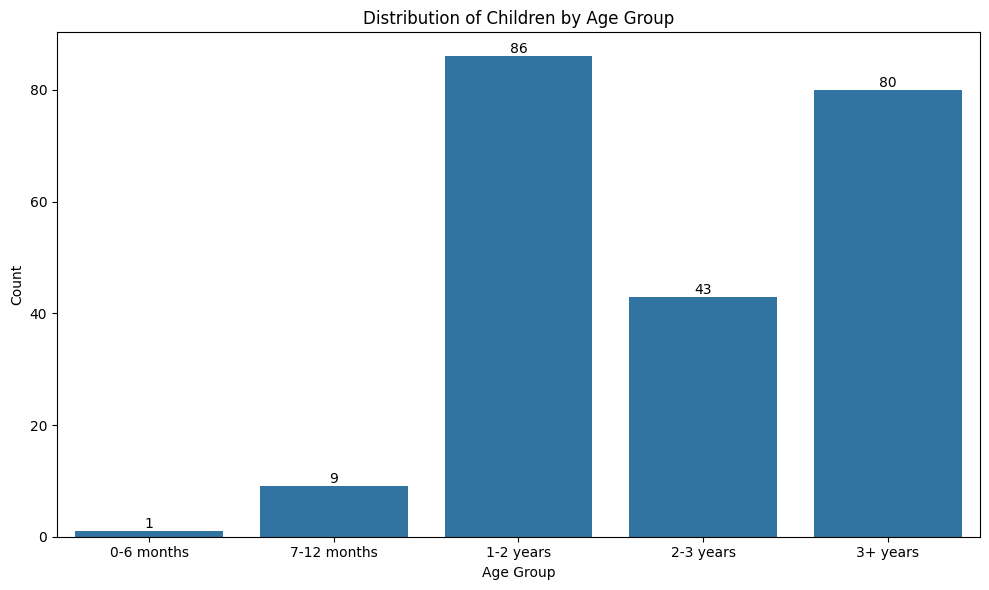

In [27]:
# Create child age variables
if 'first_child_age' in df_clean.columns:
    # Extract numeric age from strings like "2y" or "11m"
    def extract_age_months(age_str):
        if pd.isna(age_str):
            return np.nan  # Use numpy's nan instead of pandas NA

        age_str = str(age_str)
        # Extract years
        years_match = re.search(r'(\d+(?:\.\d+)?)y', age_str)
        if years_match:
            return float(years_match.group(1)) * 12

        # Extract months
        months_match = re.search(r'(\d+(?:\.\d+)?)m', age_str)
        if months_match:
            return float(months_match.group(1))

        return np.nan  # Use numpy's nan instead of pandas NA

    df_clean['first_child_age_months'] = df_clean['first_child_age'].apply(extract_age_months)

    # Drop NA values before binning or handle them explicitly
    # Method 1: Create age groups for non-NA values only
    mask = df_clean['first_child_age_months'].notna()
    df_clean.loc[mask, 'child_age_group'] = pd.cut(
        df_clean.loc[mask, 'first_child_age_months'],
        bins=[0, 6, 12, 24, 36, float('inf')],
        labels=['0-6 months', '7-12 months', '1-2 years', '2-3 years', '3+ years']
    )

    # Display child age group distribution
    child_age_counts = df_clean['child_age_group'].value_counts().sort_index()
    print("\nChild age group distribution:")
    print(child_age_counts)

    # Visualize child age groups
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='child_age_group', data=df_clean)
    plt.title("Distribution of Children by Age Group")
    plt.xlabel("Age Group")
    plt.ylabel("Count")

    # Add count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'bottom')

    plt.tight_layout()
    plt.show()

###Review and Export Cleaned Data

In [28]:
# Final data review
print(f"\nFinal cleaned dataset dimensions: {df_clean.shape}")
print("\nColumns in cleaned dataset:")
print(df_clean.columns.tolist()[:10])  # First 10 columns

# Check for remaining missing values in key columns
key_cols = ['Age', 'first_child_age', 'total_family_members']
missing_in_key = {col: df_clean[col].isna().sum() for col in key_cols if col in df_clean.columns}
print("\nMissing values in key columns:")
for col, count in missing_in_key.items():
    print(f"- {col}: {count} missing values ({count/len(df_clean)*100:.2f}%)")

# Summary statistics for key numeric variables after cleaning
print("\nSummary statistics for key variables after cleaning:")
print(df_clean[['Age', 'Partner age', 'number of children']].describe())

# Save the cleaned dataset
df_clean.to_csv('Sasilak_dataset_cleaned.csv', index=False)
print("\nCleaned dataset saved as 'Sasilak_dataset_cleaned.csv'")


Final cleaned dataset dimensions: (251, 183)

Columns in cleaned dataset:
['No', 'Schoolcode', 'Number', 'Age', 'What kind of area do you live in? (Please choose one).', 'What is your current marital status?', 'Partner age', 'number of children', 'Child gender', "Please indicate your child's gender, age, and enrollment status. ______"]

Missing values in key columns:
- Age: 0 missing values (0.00%)
- first_child_age: 28 missing values (11.16%)
- total_family_members: 0 missing values (0.00%)

Summary statistics for key variables after cleaning:
              Age  Partner age  number of children
count  251.000000   251.000000          251.000000
mean    34.350598    32.705179            1.501992
std      5.703033    13.117650            0.634820
min     17.000000     0.000000            1.000000
25%     30.500000    31.000000            1.000000
50%     34.000000    36.000000            1.000000
75%     39.000000    40.000000            2.000000
max     52.000000    55.000000          

In [29]:
!jupyter nbconvert --execute --to html "/content/Data_Analysis_Aj_Sasilak.ipynb"

[NbConvertApp] Converting notebook /content/Data_Analysis_Aj_Sasilak.ipynb to html
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 643331 bytes to /content/Data_Analysis_Aj_Sasilak.html
